# Code for generating the figures in paper

In [6]:
!if [ ! -d Figures ]; then mkdir Figures && echo made Figures directory; else echo Figures dir exists; fi

made Figures directory


In [7]:
%matplotlib notebook

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Figure 1

<IPython.core.display.Javascript object>


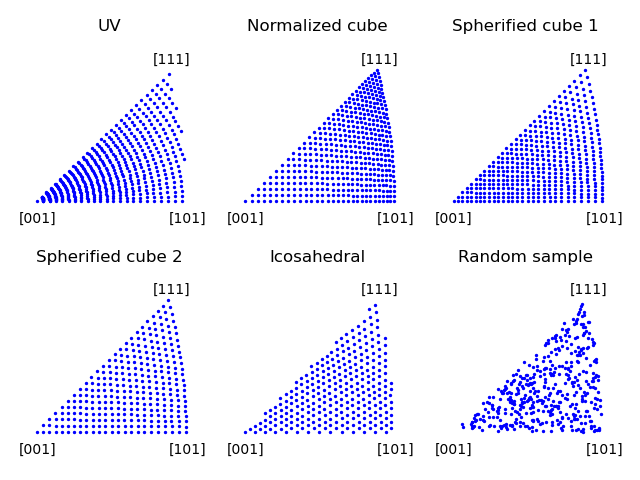

/home/din14970/Documents/Programming/PythonProjects/FORKS/diffsims/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [9]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
from orix.projections import StereographicProjection

np.random.seed(1001)

meshes = [
    ("UV", "uv_sphere"),
    ("Normalized cube", "normalized_cube"),
    ("Spherified cube 1", "spherified_cube_corner"),
    ("Spherified cube 2", "spherified_cube_edge"),
    ("Icosahedral", "icosahedral"),
    ("Random sample", "random"),
         ]

fig, axes = plt.subplots(ncols=3, nrows=2)

sp = StereographicProjection()

for ax, mesh in zip(axes.ravel(), meshes):
    ax.set_title(mesh[0])
    ax.axis("off")
    ax.set_aspect("equal")
    if mesh[1] == "random":
        sample = 0.7  # the random grid resolution is based on the average, not the maximum
    else:
        sample = 2
    full_grid = get_beam_directions_grid("cubic", sample, mesh=mesh[1])
    rotations =  Rotation.from_euler(np.deg2rad(full_grid))
    beam_dirs = rotations*Vector3d.zvector()
    ax.scatter(*sp.vector2xy(beam_dirs), s = 2, color="blue", marker="o")
    ax.set_xlim(-0.05, 0.45)
    ax.set_ylim(-0.05, 0.45)
    ax.text(0., -0.05, "[001]", ha="center", va="center")
    ax.text(0.419, -0.05, "[101]", ha="center", va="center")
    ax.text(0.375, 0.395, "[111]", ha="center", va="center")
    
fig.tight_layout()


In [10]:
fig.savefig("Figures/grids.png", dpi=640)
plt.close()

In [15]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


In [16]:
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.utils.sim_utils import get_points_in_sphere, get_kinematical_intensities
from diffsims.utils.shape_factor_models import lorentzian, linear
from transforms3d.euler import euler2mat
import diffpy

structure_aus = diffpy.structure.loadStructure("data/austeniteLP.cif")
dwf = {"Fe": 0.1}

reciprocal_radius = 1.5

reciplat = structure_aus.lattice.reciprocal()
miller, coords, dists = get_points_in_sphere(reciplat, reciprocal_radius)

# remove beam 0
miller = miller[dists != 0]
coords = coords[dists != 0]
dists = dists[dists != 0]

# rotate the coordinates
ai, aj, ak = np.deg2rad([0, 15, 5])
R = euler2mat(ai, aj, ak, axes="rzxz")
coords = np.matmul(R, coords.T).T

diff_gen = DiffractionGenerator(accelerating_voltage=10, scattering_params=None)

r_sphere = 1/diff_gen.wavelength
max_ex = 1e-2

# ewald sphere
s = 0.2
x = np.arange(-reciprocal_radius, reciprocal_radius+s, s)
y = np.arange(-reciprocal_radius, reciprocal_radius+s, s)
X, Y = np.meshgrid(x, y, indexing='ij')
Z = r_sphere - np.sqrt(r_sphere**2 - X**2 - Y**2)

# distance to ewald sphere
z_sphere = r_sphere - np.sqrt(r_sphere**2 - coords[:,0]**2 - coords[:,1]**2)
distance = np.abs(coords[:,2]-z_sphere)

shape_factor = linear(distance, 0.1)

# calculate kinematical intensities
intensities = get_kinematical_intensities(structure_aus, miller, dists, debye_waller_factors=dwf,
                                          scattering_params=None)

In [18]:
fig = mlab.figure(bgcolor=(1,1,1), size=(1200, 900))

ax_ranges = [-reciprocal_radius,
             reciprocal_radius, 
             -reciprocal_radius, 
             reciprocal_radius, 
             -reciprocal_radius,
             reciprocal_radius]
ax_scale = [1.0, 1.0, 1.0]
ax_extent = ax_ranges * np.repeat(ax_scale, 2)

# ewald sphere
minsize=0.3
surf = mlab.surf(X, Y, Z, color=(1,1,0.5), opacity=0.8)
pts = mlab.points3d(coords[:,0], coords[:, 1], coords[:, 2], scale_factor=0.1,
                    colormap= "blue-red",
                    vmin=minsize,
                    vmax=1.5, 
                   )
s = np.ones(distance.shape[0])
#pts.mlab_source.dataset.point_data.scalars = 0.8*np.log(0.05*shape_factor*intensities+1)**0.5 + minsize
pts.mlab_source.dataset.point_data.scalars = 0.1*shape_factor*intensities + minsize

surf.actor.actor.scale = ax_scale

mlab.view(53, 54, distance=7, focalpoint=[0, 0, 0], roll=240)
#mlab.outline(surf, color=(0, 0, 0), extent=ax_extent)
axes = mlab.axes(surf, color=(0, 0, 0), extent=[-1.5, 1.5, -1.5, 1.5, 0, 1],
                 nb_labels=2,
            xlabel="kx (1/nm)", ylabel='ky (1/nm)', zlabel='kz')
# axes.title_text_property.size = 10
axes.axes.label_format=''
# axes.axes.x_axis_visibility=False
# axes.axes.y_axis_visibility=False
# axes.axes.z_axis_visibility=False
axes.title_text_property.color = (0.0, 0.0, 0.0)
#axes.title_text_property.font_family = 'times'
#axes.label_text_property.color = (0.0, 0.0, 0.0)
#axes.label_text_property.font_family = 'times'

fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xb0\x00\x00\x03\x84\x08\x02\x00\x00\x00>\x0f_\xa…

In [19]:
mlab.savefig("Figures/simulate3D.png", figure=fig)

<IPython.core.display.Javascript object>


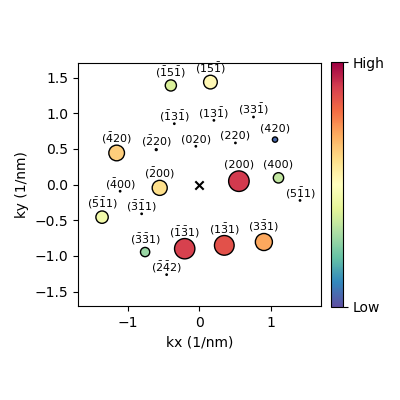

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect("equal")

condition = intensities > 1e0
condition2 = distance < 1.5e-1

coords_plot = coords[condition2 & condition]
sizes = (shape_factor*intensities)[condition2 & condition]
miller_plot = miller[condition & condition2]

vmin = 0.3
vmax = 1.6 
dummy = ax.scatter(coords_plot[:,0], coords_plot[:,1], s = sizes**2+1, c = 0.1*sizes, cmap="Spectral_r",
           vmin = vmin, vmax=vmax, edgecolor="black")
ax.scatter(0, 0, marker="x", color="black")
ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.7, 1.7)
ax.set_xlabel("kx (1/nm)")
ax.set_ylabel("ky (1/nm)")
# draw labels
for i, j, ss in zip(miller_plot, coords_plot, sizes):
    d = "("
    for k in i:
        k = int(k)
        if k<0:
            d = d + r"$\bar{" + str(abs(k)) + "}$"
        else:
            d = d + str(abs(k))
    d = d + ")"
    ax.text(j[0], j[1]+0.1+0.02*ss**0.7, d, ha="center", va="center", size=8)
    
cb = fig.colorbar(dummy, ax=ax, fraction=0.046, pad=0.04)
cb.set_ticks([vmin, vmax])
cb.set_ticklabels(['Low', 'High'])

fig.tight_layout()

In [21]:
fig.savefig("Figures/test_template.png", dpi=640)
plt.close()

[4096, 1200, 2560]
[3072, 900, 2560]
[1200, 1200, 900]


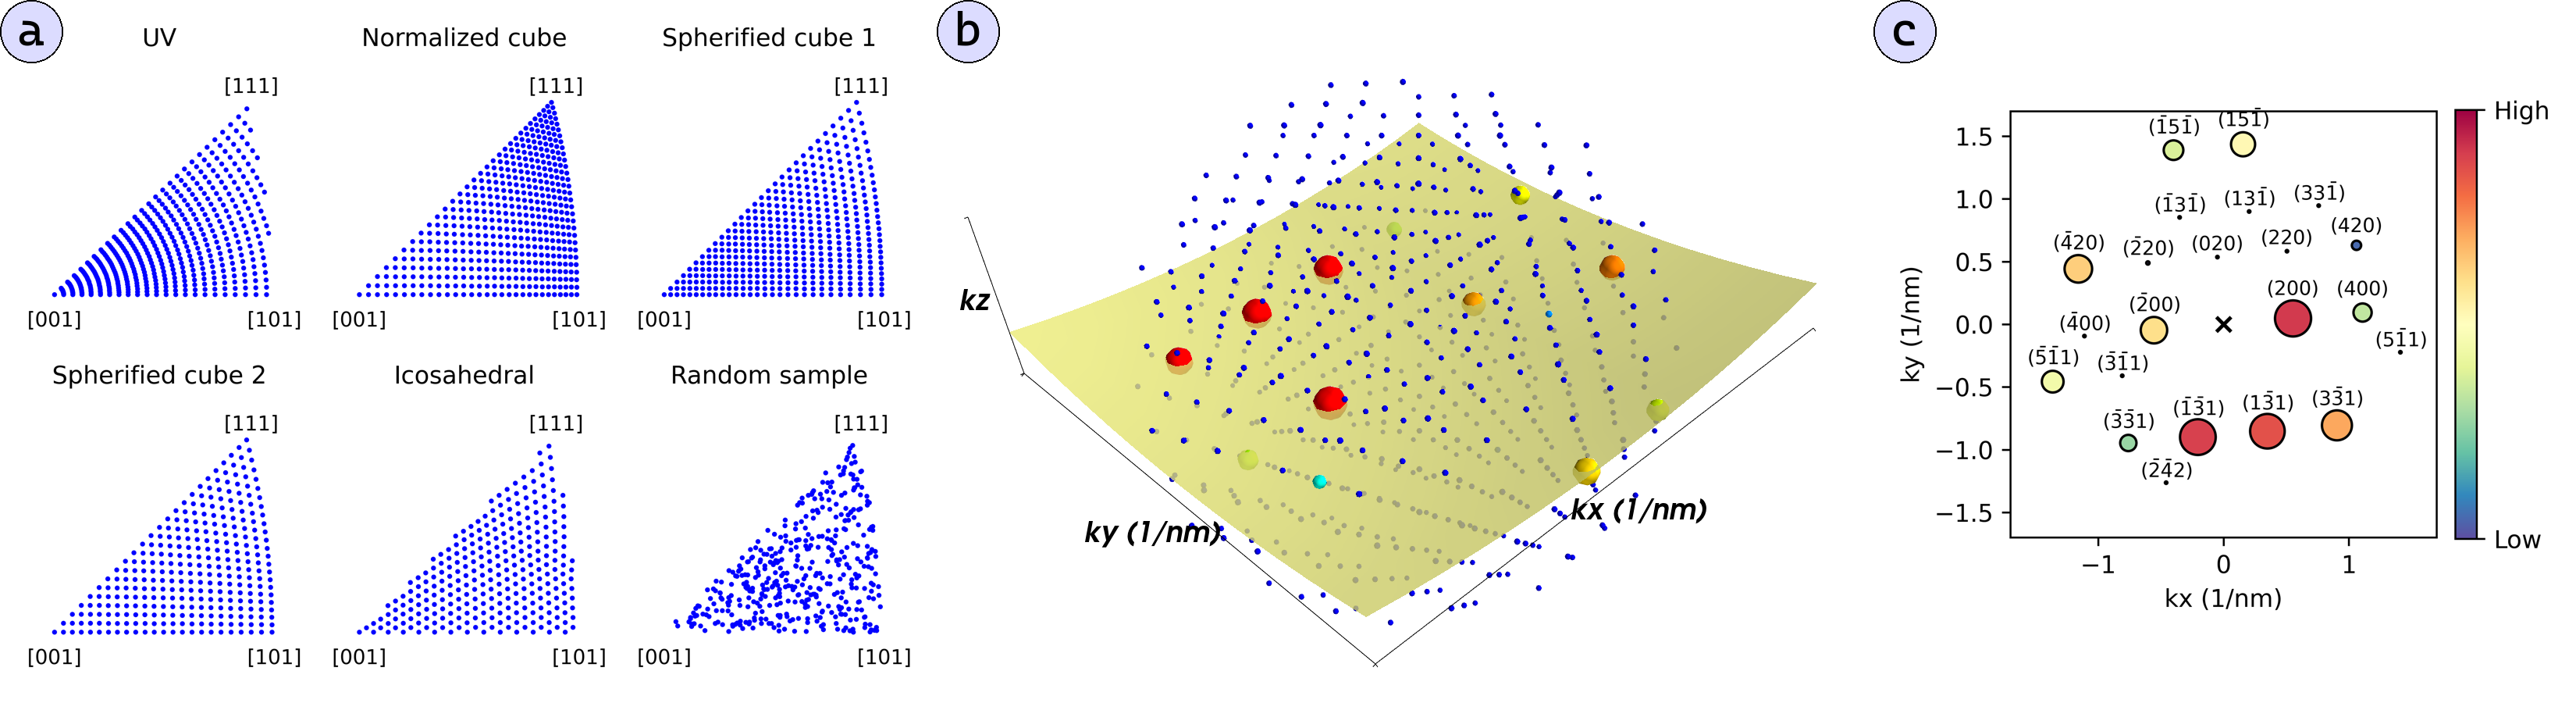

In [23]:
from PIL import Image, ImageDraw, ImageFont

listofimages=["Figures/grids.png", "Figures/simulate3D.png", "Figures/test_template.png"]

# import all images and get sizes
ims = []
widths = []
heights = []
for p in listofimages:
    im = Image.open(p)
    ims.append(im)
    widths.append(im.width)
    heights.append(im.height)
    
print(widths)
print(heights)

height = min(heights)
new_widths = []
for im in ims:
    new_width = int(im.width / im.height * height)
    new_widths.append(new_width)
    
print(new_widths)
width = sum(new_widths)
# create a new image, paste into it and annotate
new_im = Image.new('RGB', (width, height))
x = 0
positions = [x]
for i, im in enumerate(ims):
    new_width = int(im.width / im.height * height)
    im_rs = im.resize((new_width, height))
    new_im.paste(im_rs, (x, 0))
    x += new_width
    positions.append(x)
    
    

fnt = ImageFont.truetype("data/Cascadia.ttf", 60)
# annotations
draw = ImageDraw.Draw(new_im)
labels = ["a","b","c"]
s = 80
for i, lab in zip(positions, labels):
    w, h = draw.textsize(lab, font=fnt)
    draw.ellipse((i, 0, i+s, s), fill=(220, 220, 255), width=2, outline=(0,0,0))
    draw.text((i+s/2-w/2, s/2-h/1.5), lab, fill=(0,0,0), font=fnt, align="center")

new_im
#new_im.save("Collage.jpg")

In [24]:
new_im.save("Figures/Figure1_collage.png")

# Figure 2

In [25]:
import hyperspy.api as hs
from pyxem.utils import polar_transform_utils as ptu
from pyxem.utils import indexation_utils as iut
from matplotlib_scalebar.scalebar import ScaleBar

In [26]:
small_ds = hs.load("data/subset_data.hspy")

<IPython.core.display.Javascript object>


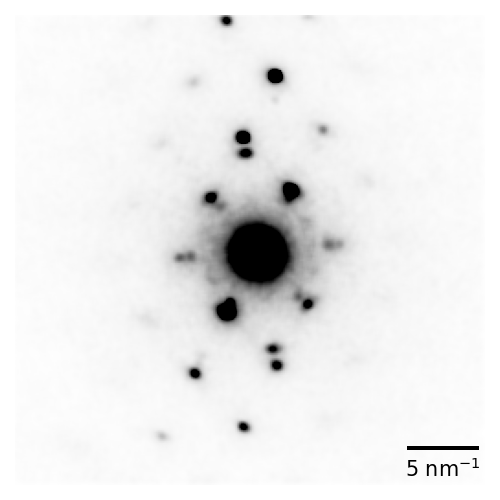

In [27]:
scale = small_ds.axes_manager[-1].scale * 10
unit = "1/nm"

image = small_ds.inav[0,0].data
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, cmap="Greys", vmax=1000)
ax.add_artist(ScaleBar(scale, units=unit, location = "lower right", dimension="si-length-reciprocal",
                       font_properties ={"size":15}, frameon=False))
ax.axis("off")
#ax.set_xticks([])
#ax.set_yticks([])
fig.tight_layout()

In [28]:
fig.savefig("Figures/f2_single_dp.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

<IPython.core.display.Javascript object>


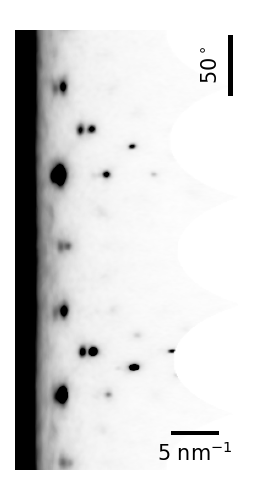

In [29]:
polar_image = ptu.image_to_polar(image, find_direct_beam=True)

# polar transform
wid = 5/polar_image.shape[0]*polar_image.shape[1]
fig, ax = plt.subplots(figsize=(wid, 5))
ax.imshow(polar_image, vmax=1000, cmap="Greys")
# r scalebar
ax.add_artist(ScaleBar(scale, units=unit, location = "lower right", dimension="si-length-reciprocal",
                       font_properties ={"size":15}, length_fraction=0.4, frameon=False))
# phi scalebar
ax.add_artist(ScaleBar(1, units="deg", location = "upper right", dimension="angle",
                       scale_loc="left", height_fraction=0.02,
                       font_properties ={"size":15}, length_fraction=0.2, rotation="vertical", frameon=False))

ax.axis("off")
fig.tight_layout()

In [30]:
fig.savefig("Figures/f2_dp_polar.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

In [32]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
import diffpy

grid = get_beam_directions_grid("cubic",1, mesh="spherified_cube_edge")
structure_aus = diffpy.structure.loadStructure("data/austeniteLP.cif")

In [33]:
# experimental values necessary to scale the simulations
half_width_image = small_ds.axes_manager["kx"].size//2
diffraction_scale = small_ds.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

In [34]:
# list of phase names, list of structures, list of orientation grids to simulate
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity = 1e-10,
                               )
library_phases = StructureLibrary(["steel"], [structure_aus], [grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_phases,
                                           calibration=diffraction_scale,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False,
                                           max_excitation_error=0.05)

<IPython.core.display.Javascript object>


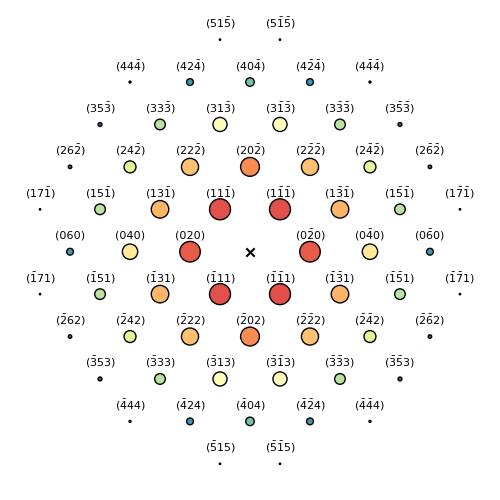

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect("equal")

sim0 = diff_lib["steel"]["simulations"][-46]
x = sim0.coordinates[:,0]
y = sim0.coordinates[:,1]
coords = sim0.coordinates
millers = sim0.indices
d = np.linalg.norm(millers, axis=1)
millers = millers[d!=0]
sizes = sim0.intensities
ax.scatter(x, y, s = sizes**2+1, c = -0.1*sizes,cmap="Spectral",
           vmin = -1.7, vmax=-0.3, edgecolor="black")
ax.scatter(0, 0, marker="x", color="black")
ax.axis("off")

# draw labels
for i, j in zip(millers, coords):
    d = "("
    for k in i:
        k = int(k)
        if k<0:
            d = d + r"$\bar{" + str(abs(k)) + "}$"
        else:
            d = d + str(abs(k))
    d = d + ")"
    ax.text(j[0], j[1]+0.15, d, ha="center", va="center", size=8)
    
#ax.invert_yaxis()
    
fig.tight_layout()

In [36]:
fig.savefig("Figures/f2_single_template.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

<IPython.core.display.Javascript object>


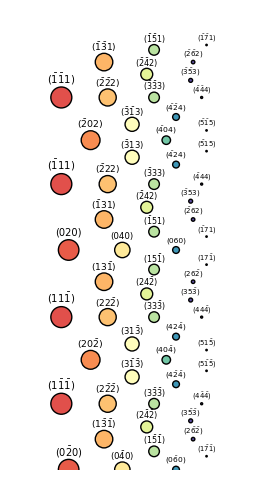

In [37]:
r, theta, i = ptu.get_template_polar_coordinates(sim0, max_r = polar_image.shape[1])

fig, ax = plt.subplots(figsize=(5 / polar_image.shape[0] * polar_image.shape[1], 5))
ax.set_aspect("equal")

ax.scatter(r, theta, s = i**2+1, c = -0.1*i,cmap="Spectral",
           vmin = -1.7, vmax=-0.3, edgecolor="black")
#ax.scatter(0, 0, marker="x", color="black")
ax.axis("off")

# draw labels
for i, j, t in zip(millers, r, theta):
    d = "("
    for k in i:
        k = int(k)
        if k<0:
            d = d + r"$\bar{" + str(abs(k)) + "}$"
        else:
            d = d + str(abs(k))
    d = d + ")"
    ax.text(j, t+18-j*0.08, d, ha="center", va="center", size=8 - j*0.02)
    
ax.set_xlim(0, polar_image.shape[1])
ax.set_ylim(0, polar_image.shape[0])
    
fig.tight_layout()

In [38]:
fig.savefig("Figures/f2_single_polar_template.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

<IPython.core.display.Javascript object>


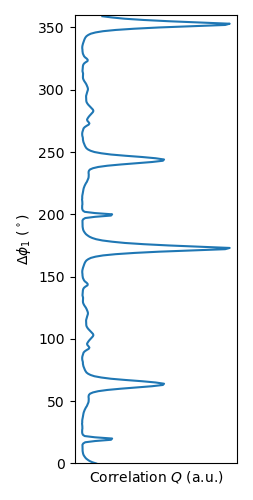

In [39]:
a, c = iut.get_in_plane_rotation_correlation(image, sim0, find_direct_beam=True)

fig, ax = plt.subplots(figsize=(5 / polar_image.shape[0] * polar_image.shape[1],5))
ax.plot(c, a)
ax.set_ylim(0, 360)
ax.set_ylabel(r"$\Delta \phi_1$ ($^\circ$)")
ax.set_xlabel(r"Correlation $Q$ (a.u.)")
ax.set_xticks([])
fig.tight_layout()

In [40]:
fig.savefig("Figures/f2_angular_match.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

In [41]:
simulations = diff_lib["steel"]["simulations"]
_, a1, c1, a2, c2 = iut.correlate_library_to_pattern(image, simulations, find_direct_beam=True,
                                                     normalize_image=True,
                                                    )

/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.21.2 (/home/din14970/miniconda3/envs/hyperspy-dev/lib/python3.8/site-packages), Requirement.parse('numpy<1.21,>=1.17'), {'numba'}))'.
  entrypoints.init_all()


In [42]:
def grid_to_xy(grid):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=-1)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

<IPython.core.display.Javascript object>


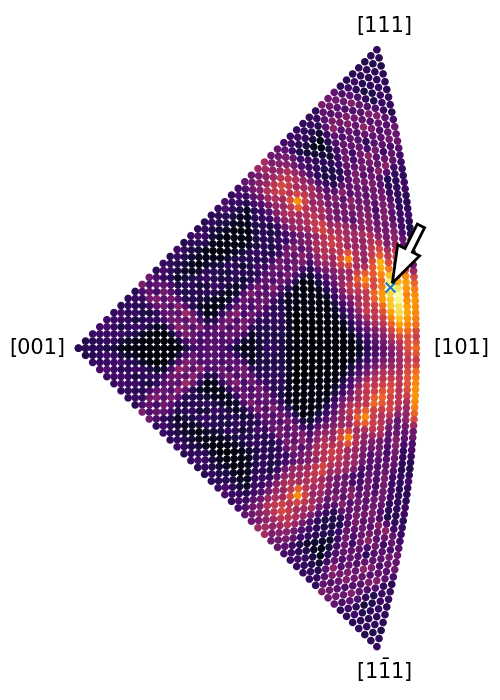

In [43]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.set_aspect("equal")
x, y = grid_to_xy(grid)
vmin = np.min(np.stack([c1, c2]))
vmax = np.max(np.stack([c1, c2]))
ax.scatter(x, y, c=c1, cmap="inferno", vmin=vmin, vmax=vmax, s=20)
ax.scatter(x, -y, c=c2, cmap="inferno", vmin=vmin, vmax=vmax, s=20)

inx = np.argmax(c1)
ax.scatter(x[inx], y[inx], marker="x", s=50)

ss = 15
ax.text(-0.05, 0, "[001]", ha="center", va="center", size=ss)
ax.text(0.47, 0, "[101]", ha="center", va="center", size=ss)
ax.text(0.375, 0.395, "[111]", ha="center", va="center", size=ss)
ax.text(0.375, -0.395, r"$[1\bar{1}1]$", ha="center", va="center", size=ss)

ax.arrow(0.42, 0.15, -0.05*0.3, -0.1*0.3, width=0.01, facecolor="white", linewidth=2)
ax.axis("off")
fig.tight_layout()

In [44]:
fig.savefig("Figures/f2_library_match.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

In [45]:
vmax

0.005861407073675957

<IPython.core.display.Javascript object>


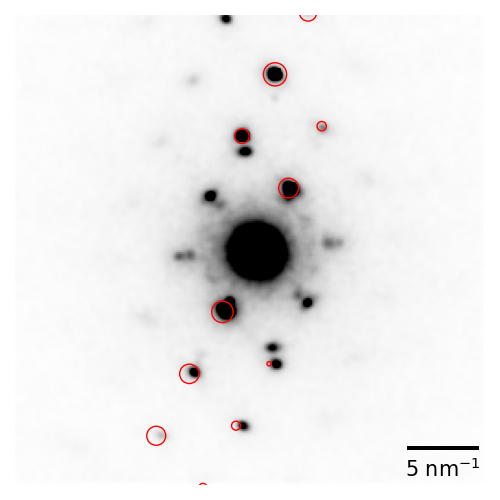

In [46]:
scale = small_ds.axes_manager[-1].scale * 10
unit = "1/nm"

image = small_ds.inav[0,0].data
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, cmap="Greys", vmax=1000)
ax.add_artist(ScaleBar(scale, units=unit, location = "lower right", dimension="si-length-reciprocal",
                       font_properties ={"size":15}, frameon=False))
ax.axis("off")

# also plot the solution
solution = simulations[inx]
best_angle = a1[inx]
x, y, into = ptu.get_template_cartesian_coordinates(solution, (131, 128), in_plane_angle=best_angle)

ax.scatter(x, y, s=into*20+1, facecolor="None", edgecolor="red")
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0],0)

fig.tight_layout()


In [47]:
fig.savefig("Figures/f2_best_match.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

In [48]:
plt.close("all")

In [49]:
%matplotlib inline

(-0.020710678118654756,
 0.4349242404917498,
 -0.40262794416288256,
 0.40262794416288256)

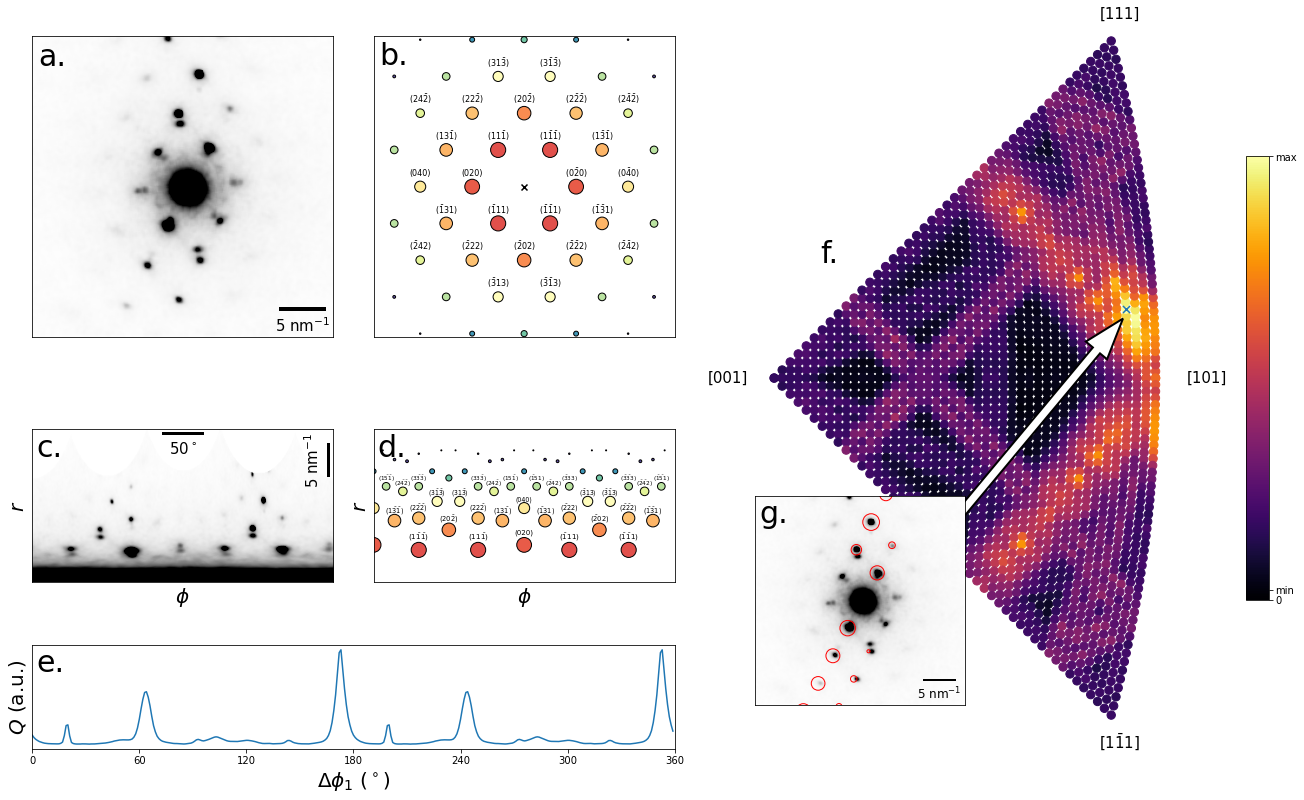

In [52]:
image = small_ds.inav[0,0].data
polar_image = ptu.image_to_polar(image, find_direct_beam=True)

# combine all the figures here in one
widths = [5, 5, 8]
h2 = widths[0]/image.shape[0]*polar_image.shape[1]
heights = [5, h2, 10-5-h2]

fig = plt.figure(constrained_layout=True, figsize=(sum(widths), sum(heights)+1))
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

labelsize = 30
axls = 20
##########################
# The image
##########################
ax0 = fig.add_subplot(spec[0,0])
scale = small_ds.axes_manager[-1].scale * 10
unit = "1/nm"
ax0.imshow(image, cmap="Greys", vmax=1000)
ax0.add_artist(ScaleBar(scale, units=unit, location = "lower right", dimension="si-length-reciprocal",
                       font_properties ={"size":15}, frameon=False))
ax0.set_xticks([])
ax0.set_yticks([])
ax0.text(5, 5, "a." , size=labelsize, ha = "left", va = "top")

##########################
# The Polar transform
##########################
ax1 = fig.add_subplot(spec[1,0])
# polar transform
ax1.imshow(np.flipud(polar_image.T), vmax=1000, cmap="Greys")
# r scalebar
ax1.add_artist(ScaleBar(scale, units=unit, location = "upper right", dimension="si-length-reciprocal",
                       font_properties ={"size":15}, length_fraction=0.4, scale_loc="left", frameon=False, rotation="vertical"))
# phi scalebar
ax1.add_artist(ScaleBar(1, units="deg", location = "upper center", dimension="angle",
                        height_fraction=0.02,
                       font_properties ={"size":15}, length_fraction=0.2, frameon=False))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(r"$\phi$", size=axls)
ax1.set_ylabel(r"$r$", size=axls)
ax1.text(5, 5, "c." , size=labelsize, ha = "left", va = "top")

########################
# Random template
########################
ax2 = fig.add_subplot(spec[0,1])
ax2.set_aspect("equal")
sim0 = diff_lib["steel"]["simulations"][-46]
x = sim0.coordinates[:,0]
y = sim0.coordinates[:,1]
coords = sim0.coordinates
millers = sim0.indices
dd = np.linalg.norm(millers, axis=1)
millers = millers[dd!=0]
dd = np.linalg.norm(millers, axis=1)
sizes = sim0.intensities
ax2.scatter(x, y, s = sizes**2+1, c = -0.1*sizes,cmap="Spectral",
           vmin = -1.7, vmax=-0.3, edgecolor="black")
ax2.scatter(0, 0, marker="x", color="black")
ax2.set_xticks([])
ax2.set_yticks([])
# draw labels
for i, j, g in zip(millers, coords, dd):
    d = "("
    for k in i:
        k = int(k)
        if k<0:
            d = d + r"$\bar{" + str(abs(k)) + "}$"
        else:
            d = d + str(abs(k))
    d = d + ")"
    if g < 5:
        ax2.text(j[0], j[1]+0.15, d, ha="center", va="center", size=8)

ax2.set_xlim(-image.shape[1]/2*scale/10, image.shape[1]/2*scale/10)
ax2.set_ylim(-image.shape[0]/2*scale/10, image.shape[0]/2*scale/10)
ax2.text(-(image.shape[1]-10)/2*scale/10, (image.shape[0]-10)/2*scale/10, "b." ,
         size=labelsize, ha = "left", va = "top")
    
#########################
# Polar transformed template
#########################
ax3 = fig.add_subplot(spec[1,1])
r, theta, i = ptu.get_template_polar_coordinates(sim0, max_r = polar_image.shape[1])
ax3.set_aspect("equal")
ax3.scatter(theta, r, s = i**2+1, c = -0.1*i,cmap="Spectral",
           vmin = -1.7, vmax=-0.3, edgecolor="black")
#ax.scatter(0, 0, marker="x", color="black")
# draw labels
for i, j, t in zip(millers, theta, r):
    d = "("
    for k in i:
        k = int(k)
        if k<0:
            d = d + r"$\bar{" + str(abs(k)) + "}$"
        else:
            d = d + str(abs(k))
    d = d + ")"
    if j > 1 and t<120:
        ax3.text(j, t+18-t*0.08, d, ha="center", va="center", size=8 - t*0.02)
    
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel(r"$\phi$", size=axls)
ax3.set_ylabel(r"$r$", size=axls)
ax3.set_ylim(0, polar_image.shape[1])
ax3.set_xlim(0, polar_image.shape[0])
ax3.text(5, polar_image.shape[1] - 5, "d." , size=labelsize, ha = "left", va = "top")
    
#############################
# The polar match
#############################
ax4 = fig.add_subplot(spec[2, 0:2])
a, c = iut.get_in_plane_rotation_correlation(image, sim0, find_direct_beam=True)
ax4.plot(a, c)
ax4.set_xlim(0, 360)
ax4.set_xlabel(r"$\Delta \phi_1$ ($^\circ$)", size=axls)
ax4.set_ylabel(r"$Q$ (a.u.)", size=axls)
ax4.set_yticks([])
ax4.set_xticks(np.arange(0, 361, 60))
ax4.text(2.5, 0.004, "e." , size=labelsize, ha = "left", va = "top")

############################
# The match to the library
############################
ax5 = fig.add_subplot(spec[:,2])
ax5.set_aspect("equal")
x, y = grid_to_xy(grid)
vmin = 0 
rvmin = np.min(np.stack([c1, c2]))
vmax = np.max(np.stack([c1, c2]))
bsf = ax5.scatter(x, y, c=c1, cmap="inferno", vmin=vmin, vmax=vmax, s=70)
ax5.scatter(x, -y, c=c2, cmap="inferno", vmin=vmin, vmax=vmax, s=70)

cb = fig.colorbar(bsf, ax=ax5, fraction=0.046, pad=0.04)
cb.set_ticks([0, rvmin, vmax])
cb.set_ticklabels([0, "min", "max"])

inx = np.argmax(c1)
ax5.scatter(x[inx], y[inx], marker="x", s=50)

ss = 15
ax5.text(-0.05, 0, "[001]", ha="center", va="center", size=ss)
ax5.text(0.47, 0, "[101]", ha="center", va="center", size=ss)
ax5.text(0.375, 0.395, "[111]", ha="center", va="center", size=ss)
ax5.text(0.375, -0.395, r"$[1\bar{1}1]$", ha="center", va="center", size=ss)
ax5.text(0.05, 0.15, "f." , size=labelsize, ha = "left", va = "top")

# plot solution
ax5in1 = ax5.inset_axes((0, -0.05, 0.5, 0.5))
ax5in1.imshow(image, cmap="Greys", vmax=1000)
ax5in1.add_artist(ScaleBar(scale, units=unit, location = "lower right", dimension="si-length-reciprocal",
                       font_properties ={"size":12}, frameon=False))
solution = simulations[inx]
best_angle = a1[inx]
x, y, into = ptu.get_template_cartesian_coordinates(solution, (131, 128), in_plane_angle=best_angle)
ax5in1.scatter(x, y, s=into*20+1, facecolor="None", edgecolor="red")
ax5in1.set_xlim(0, image.shape[1])
ax5in1.set_ylim(image.shape[0],0)
ax5in1.set_xticks([])
ax5in1.set_yticks([])
ax5in1.text(5, 5, "g." , size=labelsize, ha = "left", va = "top")

ax5.arrow(0.2, -0.15, 0.15, 0.18, width=0.01, facecolor="white", linewidth=2)
ax5.axis("off")
#ax5.set_xticks([])
#ax5.set_yticks([])

In [53]:
fig.savefig("Figures/figure2_matchingmethod.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

# Figure 3

In [54]:
rmax = polar_image.shape[1]
pos, i = iut._simulations_to_arrays(simulations, rmax)
x = pos[:, 0, :]
y = pos[:, 1, :]
r, _ = ptu._cartesian_positions_to_polar(x, y)
itemp = iut._get_integrated_polar_templates(rmax, r, i, True)

In [55]:
plt.close("all")

In [56]:
cor_f = iut.correlate_library_to_pattern_fast(image, simulations, find_direct_beam=True)

In [57]:
from matplotlib.patches import Circle

(-0.5, 22.5)

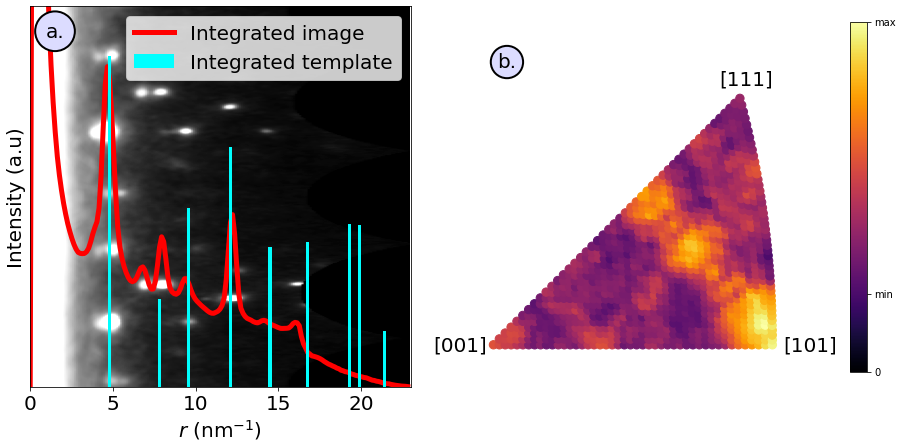

In [58]:
# polar integral
polsum = polar_image.sum(axis=0)
polsum = polsum / np.linalg.norm(polsum)

# polar template integral
#poltem = itemp[-46]  # 110
poltem = itemp[inx]  # 110
xpt = np.arange(poltem.shape[0])
condition = poltem > 0
poltem = poltem[condition]
xpt = xpt[condition]

fsf=20

fig, axes = plt.subplots(ncols = 2, figsize=(15, 7.5))
ax, ax1 = axes
#ax.set_yscale("log")
xx = np.arange(polsum.shape[0])
ax.imshow(polar_image, extent=(0, polar_image.shape[1]*scale, 0, 23), aspect="auto",
          vmax=1000, cmap="Greys_r")
ax.plot(xx*scale, polsum*xx*70, color="red", lw=5, label="Integrated image")
ax.bar(xpt*scale, poltem/np.max(poltem)*20, zorder=5, width=0.2, color="cyan", label="Integrated template")
ax.set_yticks([])
ax.tick_params(labelsize=fsf)
ax.set_ylabel("Intensity (a.u)", size=fsf)
ax.set_xlabel(r"$r$ (nm$^{-1}$)", size=fsf)
ax.set_ylim(0, 23)
ax.set_xlim(0, 23)
ax.legend(fontsize=fsf)
ax.set_aspect("equal")
ax.add_patch(Circle((1.5,21.5), radius=1.2, facecolor=(220/255, 220/255, 1), zorder=10, edgecolor="black",
                    linewidth=2))

labelsize = 20
ax.text(1.5, 21.5, "a." , size=labelsize, ha = "center", va = "center", zorder=11)

ax1.set_aspect("equal")
x, y = grid_to_xy(grid)
sff = 50
stpj = ax1.scatter(x*sff, y*sff, c=cor_f, cmap="inferno", s=70, vmin=0)
ax1.axis("off")
cb = fig.colorbar(stpj, ax=ax1, fraction=0.046, pad=0.14)
rvmin = np.min(cor_f)
vmax = np.max(cor_f)
cb.set_ticks([0, rvmin, vmax])
cb.set_ticklabels([0, "min", "max"])


ax1.text(-0.05*sff, 0, "[001]", ha="center", va="center", size=fsf)
ax1.text(0.47*sff, 0, "[101]", ha="center", va="center", size=fsf)
ax1.text(0.375*sff, 0.395*sff, "[111]", ha="center", va="center", size=fsf)

yyb = 21
ax1.add_patch(Circle((1,yyb), radius=1.2, facecolor=(220/255, 220/255, 1), zorder=10, edgecolor="black",
                    linewidth=2))
ax1.text(1, yyb, "b." , size=labelsize, ha = "center", va = "center", zorder=11)
ax1.set_xlim(-0.5, 22.5)
ax1.set_ylim(-0.5, 22.5)
#fig.tight_layout()

In [59]:
fig.savefig("Figures/figure3_polarintegrated.png", dpi=320, bbox_inches="tight", pad_inches=0.0)
plt.close()

# Benchmarking
Single image, different computational conditions

In [60]:
import pandas as pd
dtb = pd.read_csv("data/benchmark_chunk_res.csv", sep=",")
dtb = dtb.rename(columns=lambda x: x.strip())
gpu = dtb[dtb["target"] == " gpu"]
cpu = dtb[dtb["target"] == " cpu"]

In [61]:
import numpy as np
macbook_x = np.array([300, 1081, 1081])
macbook_y = np.array([17*60+15, 52*60+26.8, 58*60+19])

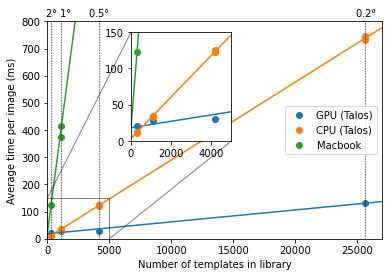

In [62]:
import matplotlib.pyplot as plt
import scipy.optimize as spo
import numpy as np

# number of images
number_of_images = 140*60

fig, ax = plt.subplots()
ax.scatter(gpu[:4]["number of templates"], gpu[:4]["indexing time"]/number_of_images*1000, label="GPU (Talos)")
ax.scatter(cpu["number of templates"], cpu["indexing time"]/number_of_images*1000, label="CPU (Talos)")
ax.scatter(macbook_x, macbook_y/number_of_images*1000, label="Macbook")
ax.set_xlabel("Number of templates in library")
ax.set_ylabel("Average time per image (ms)")

def line(x, a, b):
    return a*x+b

line1, cov1 = spo.curve_fit(line, gpu[:4]["number of templates"], gpu[:4]["indexing time"]/number_of_images*1000)
line2, cov2 = spo.curve_fit(line, cpu["number of templates"], cpu["indexing time"]/number_of_images*1000)
line3, cov3 = spo.curve_fit(line, macbook_x, macbook_y/number_of_images*1000)

xmax = 27000
x = np.arange(xmax)
ax.plot(x, line(x, *line1))
ax.plot(x, line(x, *line2))
ax.plot(x, line(x, *line3))
ax.set_xlim(0,xmax)
ax.set_ylim(0,800)

axin = ax.inset_axes([0.25, 0.45, 0.3, 0.5])
axin.scatter(gpu[:4]["number of templates"], gpu[:4]["indexing time"]/number_of_images*1000)
axin.scatter(cpu["number of templates"], cpu["indexing time"]/number_of_images*1000)
axin.scatter(macbook_x, macbook_y/number_of_images*1000)
axin.plot(x, line(x, *line1))
axin.plot(x, line(x, *line2))
axin.plot(x, line(x, *line3))
axin.set_xlim(0, 5000)
axin.set_ylim(0, 150)
ax.indicate_inset_zoom(axin, edgecolor="black")

for i, j in zip(gpu[:4]["number of templates"], [2, "   1", 0.5, 0.2]):
    ax.axvline(i, 0, 800, ls="--", lw=0.5, c="black")
    ax.text(i, 810, str(j) + r"$\degree$", ha = "center", va="bottom")

ax.legend()

In [63]:
fig.savefig("Figures/fig_benchmark_total.png", dpi=640)